In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

5816


In [2]:
import cv2
from tqdm import tqdm

In [4]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 358


In [5]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [6]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed


# Part 2: watershed

In [7]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_000.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.919s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.089s.
- Finished illumination correction in 1.188s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_000.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '40

-- corrected illumination for channel 750 in 4.250s.
-- corrected illumination for channel 488 in 4.281s.
-- corrected illumination for channel 405 in 4.218s.
- Finished illumination correction in 12.953s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -13.62 -10.62] in 0.531s.
-- drift 1: [-1.000e-02 -1.355e+01 -1.050e+01] in 0.609s.
-- drift 2: [-1.000e-02 -1.364e+01 -1.056e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-6.66666667e-03 -1.36033333e+01 -1.05600000e+01] for channel: 750
-- finish warpping channel 750 in 16.234s.
-- finish warpping in 16.234s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_3.npy
- run watershed in 78.890s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\waters

- Loaded images for channels:['488'] in 0.954s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.094s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_007.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.625s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -1.471e+01 -9.070e+00] in 0.578s.
-- drift 1: [  0.   -14.83  -9.07] in 0.625s.
-- drift 2: [  0.   -14.72  -9.06] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.47533333e+01 -9.06666667e+00] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_10.npy
- run watershed in 84.468s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_10.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_011.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_011.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_samp

-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_014.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.582s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.281s.
-- corrected illumination for channel 488 in 4.267s.
-- corrected illumination for channel 405 in 4.269s.
- Finished illumination correction in 12.962s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-6.66666667e-03 -1.41366667e+01  2.13666667e+00] for channel: 750
-- finish warpping channel 750 in 16.227s.
-- finish warpping in 16.227s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_17.npy
- run watershed in 79.540s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_17.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_018.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_018.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_018.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.378s.
-- corrected illumination for channel 488 in 4.445s.
-- corrected illumination for channel 405 in 4.424s.
- Finished illumination correction in 13.388s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -13.88   0.28] in 0.592s.
-- drift 1: [  0.04 -13.84   0.2 ] in 0.673s.
-- drift 2: [  0.04 -14.15   0.26] in 0.655s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02666667 -13.95666667

- run watershed in 70.704s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_24.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_025.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_025.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_025.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M1

-- corrected illumination for channel 750 in 4.453s.
-- corrected illumination for channel 488 in 4.472s.
-- corrected illumination for channel 405 in 4.646s.
- Finished illumination correction in 14.618s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.444e+01  3.470e+00] in 0.531s.
-- drift 1: [  0.   -14.39   3.54] in 0.567s.
-- drift 2: [  0.   -14.33   3.6 ] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.43866667e+01  3.53666667e+00] for channel: 750
-- finish warpping channel 750 in 16.496s.
-- finish warpping in 16.496s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_28.npy
- run watershed in 74.727s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segment

- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_032.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.600s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.226s.
-- corrected illuminat

-- drift 0: [  0.06 -14.76   5.22] in 0.549s.
-- drift 1: [  0.04 -14.77   5.28] in 0.656s.
-- drift 2: [  0.06 -14.69   5.29] in 0.583s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05333333 -14.74         5.26333333] for channel: 750
-- finish warpping channel 750 in 16.310s.
-- finish warpping in 16.310s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_35.npy
- run watershed in 79.722s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_35.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_036.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_0

-- corrected illumination for channel 488 in 1.123s.
- Finished illumination correction in 1.170s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_039.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.905s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.238s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.395s.
- Finished illumination correction in 13.009s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-3.33333333e-03 -1.38366667e+01  6.67333333e+00] for channel: 750
-- finish warpping channel 750 in 16.272s.
-- finish warpping in 16.272s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_42.npy
- run watershed in 82.621s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_42.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_043.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 9.148s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.548s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.253s.
-- corrected illumination for channel 488 in 4.255s.
-- corrected illumination for channel 405 in 4.191s.
- Finished illumination correction in 12.824s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.05 -16.06  20.28] in 0.562s.
-- drift 1: [  0.05 -16.27  20.45] in 0.548s.
-- drift 2: [  0.07 -16.28  20.29] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05666667 -16.20333333

- run watershed in 82.637s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_49.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_050.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.203s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M1

-- corrected illumination for channel 750 in 4.676s.
-- corrected illumination for channel 488 in 4.551s.
-- corrected illumination for channel 405 in 4.269s.
- Finished illumination correction in 13.512s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -17.42   3.64] in 0.531s.
-- drift 1: [  0.02 -17.47   3.68] in 0.547s.
-- drift 2: [  0.02 -17.31   3.73] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02       -17.4          3.68333333] for channel: 750
-- finish warpping channel 750 in 16.291s.
-- finish warpping in 16.291s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_53.npy
- run watershed in 89.204s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_53.npy
re

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.129s.
- Finished illumination correction in 1.160s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_057.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.734s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.228s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -1.352e+01 -8.500e+00] in 0.531s.
-- drift 1: [ 1.000e-02 -1.358e+01 -8.410e+00] in 0.562s.
-- drift 2: [ 1.000e-02 -1.341e+01 -8.510e+00] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -1.35033333e+01 -8.47333333e+00] for channel: 750
-- finish warpping channel 750 in 16.190s.
-- finish warpping in 16.190s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_60.npy
- run watershed in 81.904s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_60.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_061.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_061.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_

- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.140s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_064.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.691s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.505s.
-- corrected illuminat

-- drift 0: [  0.02 -13.71   2.83] in 0.640s.
-- drift 1: [  0.   -13.93   3.02] in 0.609s.
-- drift 2: [  0.02 -13.81   2.95] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -1.38166667e+01  2.93333333e+00] for channel: 750
-- finish warpping channel 750 in 16.379s.
-- finish warpping in 16.379s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_67.npy
- run watershed in 77.121s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_67.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_068.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_068.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Con

-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.265s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_071.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.582s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.192s.
-- corrected illumination for channel 488 in 4.249s.
-- corrected illumination for channel 405 in 4.255s.
- Finished illumination correction in 12.836s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-1.33333333e-02 -1.37933333e+01  7.30000000e-01] for channel: 750
-- finish warpping channel 750 in 16.235s.
-- finish warpping in 16.235s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_74.npy
- run watershed in 86.275s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_74.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_075.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_075.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_075.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.680s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.504s.
-- corrected illumination for channel 488 in 4.596s.
-- corrected illumination for channel 405 in 4.398s.
- Finished illumination correction in 13.623s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -14.21   2.75] in 0.531s.
-- drift 1: [  0.   -14.18   2.89] in 0.640s.
-- drift 2: [  0.   -14.22   2.91] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.         -14.20333333

- run watershed in 79.903s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_81.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_082.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_082.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_082.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M1

- Loaded images for channels:['750', '488', '405'] in 2.568s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.251s.
-- corrected illumination for channel 488 in 4.212s.
-- corrected illumination for channel 405 in 4.209s.
- Finished illumination correction in 12.937s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.465e+01  1.030e+00] in 0.578s.
-- drift 1: [ -0.02 -14.93   0.94] in 0.599s.
-- drift 2: [  0.   -14.56   0.99] in 0.640s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-

- run watershed in 85.392s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_88.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_089.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_089.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_089.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M1

-- corrected illumination for channel 750 in 4.207s.
-- corrected illumination for channel 488 in 4.224s.
-- corrected illumination for channel 405 in 4.285s.
- Finished illumination correction in 12.857s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -14.02   3.84] in 0.687s.
-- drift 1: [  0.02 -14.07   3.98] in 0.562s.
-- drift 2: [  0.03 -14.15   4.01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02333333 -14.08         3.94333333] for channel: 750
-- finish warpping channel 750 in 16.235s.
-- finish warpping in 16.235s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_92.npy
- run watershed in 91.640s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_92.npy
re

- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_096.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.942s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 5.020s.
-- corrected illuminat

-- drift 0: [  0.02 -14.45   8.73] in 0.562s.
-- drift 1: [  0.02 -14.28   9.04] in 0.604s.
-- drift 2: [  0.03 -14.24   9.  ] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02333333 -14.32333333   8.92333333] for channel: 750
-- finish warpping channel 750 in 16.268s.
-- finish warpping in 16.268s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_99.npy
- run watershed in 90.184s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_99.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_100.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_100.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_1

-- corrected illumination for channel 488 in 1.265s.
- Finished illumination correction in 1.265s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_103.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.755s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.677s.
-- corrected illumination for channel 488 in 4.738s.
-- corrected illumination for channel 405 in 4.536s.
- Finished illumination correction in 13.982s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.03666667 -14.80333333   8.55666667] for channel: 750
-- finish warpping channel 750 in 16.372s.
-- finish warpping in 16.372s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_106.npy
- run watershed in 83.427s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_106.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_107.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_107.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_107.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 3.364s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.208s.
-- corrected illumination for channel 488 in 4.239s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 12.838s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.09 -13.76   4.22] in 0.547s.
-- drift 1: [ -0.17 -13.55   4.4 ] in 0.552s.
-- drift 2: [ -0.07 -13.61   4.15] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.11       -13.64      

- run watershed in 79.102s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_113.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_114.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_114.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_114.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.193s.
- Finished illumination correction in 1.208s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.609s.
-- corrected illumination for channel 488 in 4.321s.
-- corrected illumination for channel 405 in 4.410s.
- Finished illumination correction in 13.450s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 6.000e-01 -1.456e+01 -1.000e-02] in 0.579s.
-- drift 1: [  0.61 -14.16   0.03] in 0.562s.
-- drift 2: [  0.61 -14.42   0.02] in 0.568s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.06666667e-01 -1.43800000e+01  1.33333333e-02] for channel: 750
-- finish warpping channel 750 in 16.307s.
-- finish warpping in 16.307s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_117.npy
- run watershed in 74.369s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmen

- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.208s.
- Finished illumination correction in 1.255s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_121.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.693s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.425s.
-- corrected illuminat

-- drift 0: [  0.05 -14.17   2.44] in 0.562s.
-- drift 1: [  0.04 -14.22   2.36] in 0.594s.
-- drift 2: [  0.06 -14.41   2.47] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.05       -14.26666667   2.42333333] for channel: 750
-- finish warpping channel 750 in 16.202s.
-- finish warpping in 16.202s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_124.npy
- run watershed in 94.614s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_124.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_125.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_125.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.250s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_128.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.702s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.425s.
-- corrected illumination for channel 488 in 4.238s.
-- corrected illumination for channel 405 in 4.208s.
- Finished illumination correction in 13.136s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.01666667 -14.64666667   2.02666667] for channel: 750
-- finish warpping channel 750 in 16.313s.
-- finish warpping in 16.313s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_131.npy
- run watershed in 87.086s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_131.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_132.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_132.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_132.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.707s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.256s.
-- corrected illumination for channel 488 in 4.263s.
-- corrected illumination for channel 405 in 4.267s.
- Finished illumination correction in 12.958s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.03 -14.5    1.61] in 0.536s.
-- drift 1: [  0.04 -14.43   1.8 ] in 0.594s.
-- drift 2: [  0.05 -14.44   1.68] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04       -14.45666667

- run watershed in 86.080s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_138.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_139.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_139.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_139.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.156s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.191s.
-- corrected illumination for channel 488 in 4.317s.
-- corrected illumination for channel 405 in 4.473s.
- Finished illumination correction in 13.168s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.473e+01  6.940e+00] in 0.635s.
-- drift 1: [-1.000e-02 -1.459e+01  7.120e+00] in 0.531s.
-- drift 2: [-1.000e-02 -1.458e+01  6.950e+00] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.46333333e+01  7.00333333e+00] for channel: 750
-- finish warpping channel 750 in 16.243s.
-- finish warpping in 16.243s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_142.npy
- run watershed in 89.069s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segme

- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.223s.
- Finished illumination correction in 1.395s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_146.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.718s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.514s.
-- corrected illuminat

-- drift 0: [ -0.02 -15.05   0.84] in 0.594s.
-- drift 1: [ -0.06 -15.46   1.05] in 0.547s.
-- drift 2: [ -0.02 -14.94   0.94] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03333333 -15.15         0.94333333] for channel: 750
-- finish warpping channel 750 in 16.184s.
-- finish warpping in 16.184s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_149.npy
- run watershed in 80.655s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_149.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_150.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_150.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.109s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_153.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.769s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.505s.
-- corrected illumination for channel 488 in 4.295s.
-- corrected illumination for channel 405 in 4.253s.
- Finished illumination correction in 13.084s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.08666667 -14.56666667   1.41666667] for channel: 750
-- finish warpping channel 750 in 16.405s.
-- finish warpping in 16.405s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_156.npy
- run watershed in 90.764s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_156.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_157.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_157.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_157.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 11.422s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.207s.
-- corrected illumination for channel 488 in 4.255s.
-- corrected illumination for channel 405 in 4.339s.
- Finished illumination correction in 13.332s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02 -14.56   2.45] in 0.536s.
-- drift 1: [ -0.02 -14.36   2.6 ] in 0.636s.
-- drift 2: [ -0.02 -14.4    2.58] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp ima

- run watershed in 95.609s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_163.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_164.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_164.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_164.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.241s.
-- corrected illumination for channel 488 in 4.293s.
-- corrected illumination for channel 405 in 4.483s.
- Finished illumination correction in 13.126s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.03 -14.88  14.5 ] in 0.567s.
-- drift 1: [  0.03 -14.82  14.39] in 0.609s.
-- drift 2: [  0.02 -14.87  14.31] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02666667 -14.85666667  14.4       ] for channel: 750
-- finish warpping channel 750 in 16.355s.
-- finish warpping in 16.355s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_167.npy
- run watershed in 101.567s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_167.npy

- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.218s.
- Finished illumination correction in 1.265s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_171.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.551s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.707s.
-- corrected illuminat

-- drift 0: [  0.04 -13.86  -3.02] in 0.531s.
-- drift 1: [  0.02 -13.83  -3.02] in 0.719s.
-- drift 2: [  0.03 -13.61  -3.01] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03       -13.76666667  -3.01666667] for channel: 750
-- finish warpping channel 750 in 16.335s.
-- finish warpping in 16.335s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_174.npy
- run watershed in 91.850s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_174.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_175.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_175.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.140s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_178.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.910s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.297s.
-- corrected illumination for channel 488 in 4.438s.
-- corrected illumination for channel 405 in 4.706s.
- Finished illumination correction in 13.644s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.01666667 -12.73         5.22333333] for channel: 750
-- finish warpping channel 750 in 16.357s.
-- finish warpping in 16.357s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_181.npy
- run watershed in 95.292s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_181.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_182.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_182.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_182.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.989s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.677s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.235s.
-- corrected illumination for channel 488 in 4.239s.
-- corrected illumination for channel 405 in 4.270s.
- Finished illumination correction in 12.900s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -15.4    0.77] in 0.547s.
-- drift 1: [-1.000e-02 -1.549e+01  8.700e-01] in 0.562s.
-- drift 2: [ 1.000e-02 -1.523e+01  6.500e-01] in 0.583s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 80.903s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_188.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_189.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_189.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_189.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.988s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.233s.
-- corrected illumination for channel 488 in 4.364s.
-- corrected illumination for channel 405 in 4.378s.
- Finished illumination correction in 13.152s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.469e+01  3.500e-01] in 0.547s.
-- drift 1: [  0.02 -14.56   0.29] in 0.578s.
-- drift 2: [  0.02 -14.46   0.32] in 0.565s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.01666667 -14.57         0.32      ] for channel: 750
-- finish warpping channel 750 in 16.252s.
-- finish warpping in 16.252s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_192.npy
- run watershed in 84.554s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_la

- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_196.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.657s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.225s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -1.422e+01  2.850e+00] in 0.547s.
-- drift 1: [ 1.00e-02 -1.40e+01  2.88e+00] in 0.578s.
-- drift 2: [  0.   -14.12   2.9 ] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 6.66666667e-03 -1.41133333e+01  2.87666667e+00] for channel: 750
-- finish warpping channel 750 in 16.238s.
-- finish warpping in 16.238s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_199.npy
- run watershed in 83.626s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_199.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_200.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_200.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hM

-- corrected illumination for channel 488 in 1.172s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_203.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.630s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.640s.
-- corrected illumination for channel 488 in 4.662s.
-- corrected illumination for channel 405 in 4.550s.
- Finished illumination correction in 13.883s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.01666667 -13.82        -1.23666667] for channel: 750
-- finish warpping channel 750 in 16.158s.
-- finish warpping in 16.158s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_206.npy
- run watershed in 76.874s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_206.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_207.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_207.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_207.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.987s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.217s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.159s.
- Finished illumination correction in 12.751s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.433e+01  4.450e+00] in 0.578s.
-- drift 1: [ -0.03 -14.36   4.54] in 0.570s.
-- drift 2: [-1.000e-02 -1.431e+01  4.430e+00] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 88.157s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_213.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_214.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_214.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_214.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.234s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.222s.
-- corrected illumination for channel 488 in 4.272s.
-- corrected illumination for channel 405 in 4.239s.
- Finished illumination correction in 13.076s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04 -14.04   2.28] in 0.562s.
-- drift 1: [ -0.04 -13.99   2.35] in 0.609s.
-- drift 2: [ -0.04 -14.01   2.29] in 0.565s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.04       -14.01333333   2.30666667] for channel: 750
-- finish warpping channel 750 in 16.432s.
-- finish warpping in 16.432s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_217.npy
- run watershed in 87.358s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Se

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.145s.
- Finished illumination correction in 1.270s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_221.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.718s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.378s.
-- corrected illuminat

-- drift 0: [ -0.08 -14.9    2.7 ] in 0.602s.
-- drift 1: [ -0.1  -14.88   2.81] in 0.625s.
-- drift 2: [ -0.09 -14.85   2.82] in 0.620s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.09       -14.87666667   2.77666667] for channel: 750
-- finish warpping channel 750 in 16.289s.
-- finish warpping in 16.289s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_224.npy
- run watershed in 88.196s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_224.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_225.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_225.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.082s.
- Finished illumination correction in 1.160s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_228.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.206s.
-- corrected illumination for channel 488 in 4.208s.
-- corrected illumination for channel 405 in 4.301s.
- Finished illumination correction in 12.872s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.04333333 -14.49333333  -0.08      ] for channel: 750
-- finish warpping channel 750 in 16.222s.
-- finish warpping in 16.222s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_231.npy
- run watershed in 78.444s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_231.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_232.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_232.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_232.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.968s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.529s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.303s.
-- corrected illumination for channel 488 in 4.254s.
-- corrected illumination for channel 405 in 4.311s.
- Finished illumination correction in 13.009s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.03 -14.12   7.55] in 0.552s.
-- drift 1: [  0.02 -14.26   7.6 ] in 0.625s.
-- drift 2: [  0.02 -14.22   7.42] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02333333 -14.2       

- run watershed in 78.049s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_238.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_239.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_239.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_239.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.922s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.442s.
-- corrected illumination for channel 488 in 4.377s.
-- corrected illumination for channel 405 in 4.629s.
- Finished illumination correction in 13.620s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -1.394e+01  1.470e+00] in 0.605s.
-- drift 1: [-1.000e-02 -1.402e+01  1.480e+00] in 0.562s.
-- drift 2: [-1.00e-02 -1.39e+01  1.32e+00] in 0.672s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.39533333e+01  1.42333333e+00] for channel: 750
-- finish warpping channel 750 in 16.357s.
-- finish warpping in 16.357s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_242.npy
- run watershed in 87.207s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmenta

- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.064s.
- Finished illumination correction in 1.126s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_246.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.566s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.286s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -1.486e+01  1.440e+00] in 0.531s.
-- drift 1: [-1.000e-02 -1.493e+01  1.660e+00] in 0.621s.
-- drift 2: [-1.000e-02 -1.482e+01  1.560e+00] in 0.589s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -1.48700000e+01  1.55333333e+00] for channel: 750
-- finish warpping channel 750 in 16.281s.
-- finish warpping in 16.281s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_249.npy
- run watershed in 75.147s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_249.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_250.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_250.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.937s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.073s.
- Finished illumination correction in 1.135s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_253.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.598s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.223s.
-- corrected illuminat

-- drift 0: [ -0.03 -14.6    5.22] in 0.611s.
-- drift 1: [ -0.04 -14.58   5.25] in 0.594s.
-- drift 2: [ -0.03 -14.57   5.24] in 0.599s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03333333 -14.58333333   5.23666667] for channel: 750
-- finish warpping channel 750 in 16.513s.
-- finish warpping in 16.513s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_256.npy
- run watershed in 82.275s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_256.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_257.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_257.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.083s.
- Finished illumination correction in 1.114s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_260.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.660s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.245s.
-- corrected illumination for channel 488 in 4.441s.
-- corrected illumination for channel 405 in 4.241s.
- Finished illumination correction in 13.067s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.02666667 -14.13333333  -5.25333333] for channel: 750
-- finish warpping channel 750 in 16.248s.
-- finish warpping in 16.248s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_263.npy
- run watershed in 82.550s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_263.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_264.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_264.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_264.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 3.051s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.567s.
-- corrected illumination for channel 488 in 4.675s.
-- corrected illumination for channel 405 in 4.735s.
- Finished illumination correction in 16.024s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -14.04   2.47] in 0.635s.
-- drift 1: [ -0.02 -14.07   2.72] in 0.656s.
-- drift 2: [  0.   -14.03   2.62] in 0.646s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-6.66666667e-03 -1.404666

- run watershed in 80.403s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_270.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_271.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_271.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_271.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.093s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.130s.
- Finished illumination correction in 1.192s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.343s.
-- corrected illumination for channel 488 in 4.191s.
-- corrected illumination for channel 405 in 4.270s.
- Finished illumination correction in 12.929s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02 -1.164e+01  2.550e+00] in 0.640s.
-- drift 1: [  0.   -11.81   2.61] in 0.531s.
-- drift 2: [  0.02 -11.7    2.58] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -1.17166667e+01  2.58000000e+00] for channel: 750
-- finish warpping channel 750 in 16.294s.
-- finish warpping in 16.294s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_274.npy
- run watershed in 92.152s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmen

- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.068s.
- Finished illumination correction in 1.115s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_278.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.624s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.253s.
-- corrected illuminat

-- drift 0: [ -0.04 -15.02   4.08] in 0.600s.
-- drift 1: [ -0.03 -14.8    4.34] in 0.601s.
-- drift 2: [ -0.05 -14.69   4.28] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.04       -14.83666667   4.23333333] for channel: 750
-- finish warpping channel 750 in 16.225s.
-- finish warpping in 16.225s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_281.npy
- run watershed in 88.397s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_281.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_282.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_282.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_285.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.722s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.647s.
-- corrected illumination for channel 488 in 4.832s.
-- corrected illumination for channel 405 in 4.770s.
- Finished illumination correction in 14.265s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.01666667 -13.72        -2.39      ] for channel: 750
-- finish warpping channel 750 in 16.355s.
-- finish warpping in 16.355s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_288.npy
- run watershed in 88.782s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_288.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_289.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_289.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_289.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.045s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.728s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.599s.
-- corrected illumination for channel 488 in 4.802s.
-- corrected illumination for channel 405 in 4.615s.
- Finished illumination correction in 14.047s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -14.26   1.66] in 0.515s.
-- drift 1: [ -0.05 -14.16   1.87] in 0.640s.
-- drift 2: [ -0.04 -14.11   1.71] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.04       -14.17666667

- run watershed in 93.045s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_295.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_296.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_296.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_296.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.067s.
- Finished illumination correction in 1.129s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.240s.
-- corrected illumination for channel 488 in 4.269s.
-- corrected illumination for channel 405 in 4.316s.
- Finished illumination correction in 12.981s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -15.24   2.43] in 0.562s.
-- drift 1: [  0.   -15.26   2.5 ] in 0.547s.
-- drift 2: [ 1.000e-02 -1.521e+01  2.480e+00] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -1.52366667e+01  2.47000000e+00] for channel: 750
-- finish warpping channel 750 in 16.130s.
-- finish warpping in 16.130s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_299.npy
- run watershed in 96.767s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmen

- Loaded images for channels:['488'] in 1.052s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.265s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_303.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.532s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.206s.
-- corrected illuminat

-- drift 0: [  0.02 -14.27   4.79] in 0.687s.
-- drift 1: [ 1.000e-02 -1.444e+01  5.010e+00] in 0.578s.
-- drift 2: [ 1.000e-02 -1.437e+01  4.960e+00] in 0.640s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -1.43600000e+01  4.92000000e+00] for channel: 750
-- finish warpping channel 750 in 16.323s.
-- finish warpping in 16.323s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_306.npy
- run watershed in 89.375s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_306.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_307.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_307.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011

-- corrected illumination for channel 488 in 1.229s.
- Finished illumination correction in 1.245s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_310.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.682s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.751s.
-- corrected illumination for channel 488 in 4.786s.
-- corrected illumination for channel 405 in 4.567s.
- Finished illumination correction in 14.150s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.04333333 -13.90333333   6.05666667] for channel: 750
-- finish warpping channel 750 in 16.137s.
-- finish warpping in 16.137s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_313.npy
- run watershed in 90.862s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_313.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_314.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_314.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_314.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.023s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.677s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.270s.
-- corrected illumination for channel 488 in 4.253s.
-- corrected illumination for channel 405 in 4.188s.
- Finished illumination correction in 12.914s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -13.62  -8.16] in 0.531s.
-- drift 1: [ 1.000e-02 -1.348e+01 -8.170e+00] in 0.598s.
-- drift 2: [  0.02 -13.59  -8.21] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.01666667 

- run watershed in 86.488s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_320.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_321.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_321.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_321.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.129s.
- Finished illumination correction in 1.223s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.238s.
-- corrected illumination for channel 488 in 4.270s.
-- corrected illumination for channel 405 in 4.284s.
- Finished illumination correction in 12.948s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -14.4   -5.14] in 0.562s.
-- drift 1: [-1.000e-02 -1.424e+01 -5.120e+00] in 0.609s.
-- drift 2: [-1.000e-02 -1.422e+01 -5.150e+00] in 0.532s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-6.66666667e-03 -1.42866667e+01 -5.13666667e+00] for channel: 750
-- finish warpping channel 750 in 16.281s.
-- finish warpping in 16.281s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_324.npy
- run watershed in 98.911s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\wate

- Loaded images for channels:['488'] in 1.001s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.114s.
- Finished illumination correction in 1.192s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_328.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.581s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.262s.
-- corrected illuminat

-- drift 0: [  0.06 -14.7    4.01] in 0.578s.
-- drift 1: [  0.04 -14.58   4.15] in 0.610s.
-- drift 2: [  0.04 -14.64   4.17] in 0.583s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.04666667 -14.64         4.11      ] for channel: 750
-- finish warpping channel 750 in 16.262s.
-- finish warpping in 16.262s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_331.npy
- run watershed in 86.491s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_331.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_332.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_332.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.187s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_335.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.110s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.581s.
-- corrected illumination for channel 488 in 4.739s.
-- corrected illumination for channel 405 in 4.614s.
- Finished illumination correction in 15.782s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.02666667 -15.07333333   2.58333333] for channel: 750
-- finish warpping channel 750 in 16.705s.
-- finish warpping in 16.705s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_338.npy
- run watershed in 86.424s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_338.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_339.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_339.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_339.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.597s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.187s.
-- corrected illumination for channel 488 in 4.410s.
-- corrected illumination for channel 405 in 4.395s.
- Finished illumination correction in 13.102s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -13.82  -4.55] in 0.625s.
-- drift 1: [  0.   -13.8   -4.51] in 0.547s.
-- drift 2: [  0.   -13.8   -4.56] in 0.567s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.         -13.80666667

- run watershed in 86.581s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_345.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_346.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_346.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_346.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.035s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M

-- corrected illumination for channel 750 in 4.182s.
-- corrected illumination for channel 488 in 4.184s.
-- corrected illumination for channel 405 in 4.238s.
- Finished illumination correction in 12.712s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.02 -14.17   4.18] in 0.609s.
-- drift 1: [ 1.000e-02 -1.416e+01  4.210e+00] in 0.500s.
-- drift 2: [  0.03 -14.12   4.2 ] in 0.609s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.02       -14.15         4.19666667] for channel: 750
-- finish warpping channel 750 in 16.147s.
-- finish warpping in 16.147s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_349.npy
- run watershed in 86.069s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_la

- Loaded images for channels:['488'] in 1.140s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_353.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.067s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.161s.
-- corrected illuminat

-- drift 0: [  0.03 -14.41 -15.33] in 0.564s.
-- drift 1: [ 1.000e-02 -1.449e+01 -1.532e+01] in 0.547s.
-- drift 2: [  0.38 -14.44 -15.3 ] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.14       -14.44666667 -15.31666667] for channel: 750
-- finish warpping channel 750 in 16.188s.
-- finish warpping in 16.188s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\segmentation_label_356.npy
- run watershed in 65.617s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\Segmentation\watershed\segmentation_label_356.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M1\Conv_zscan_357.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H11M12\Conv_zscan_357.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221011-hMTG_hM1_sample5\H0M

<IPython.core.display.Javascript object>


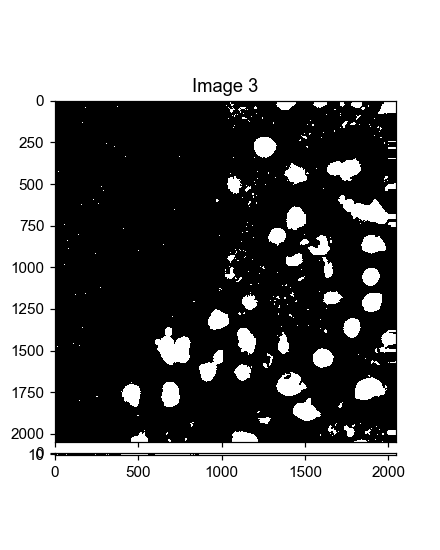

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


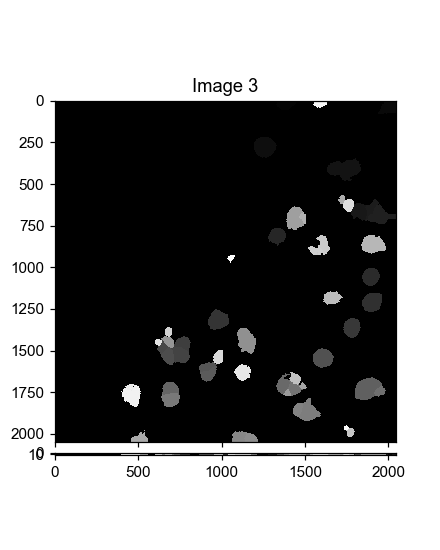

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels])

In [ ]:
wate